# Notebook 4: Transfer Learning con ResNet50

## ¿Qué hace este notebook?
Usamos **ResNet50**, un modelo más grande y profundo que MobileNetV2, también pre-entrenado con millones de imágenes.

## ¿Por qué ResNet50?
ResNet ganó competencias de clasificación de imágenes y es conocido por su capacidad de aprender patrones muy complejos gracias a sus "conexiones residuales".

## Dos estrategias probadas:
1. **Feature Extraction**: Usamos el modelo como extractor de características
2. **Fine Tuning**: Ajustamos las últimas capas para nuestro problema específico

## Resultados Obtenidos
| Estrategia | Precisión en Test |
|------------|------------------|
| Feature Extraction | 95.91% |
| Fine Tuning | **96.69%** ⭐ |

🏆 **ResNet50 con Fine Tuning es el mejor modelo de todo el proyecto.**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuración
DATASET_DIR = 'dataset_split'
IMG_SIZE = (224, 224) # ResNet expects 224x224
BATCH_SIZE = 32
EPOCHS_FE = 5
EPOCHS_FT = 5
CLASSES = ['cavallo', 'elefante', 'gallina', 'mucca', 'pecora']

2025-12-16 21:18:22.791756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 21:18:22.834390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 21:18:23.948264: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Carga de Datos y Preprocesamiento

In [2]:
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'val'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'test'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False
    )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()

Found 3615 files belonging to 5 classes.
Found 1805 files belonging to 5 classes.
Found 1810 files belonging to 5 classes.


2025-12-16 21:18:27.106344: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 1. Feature Extraction

In [3]:
# Pre-processing pipeline
preprocess_layer = preprocess_input 

# Base Model
base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False # FREEZE

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = preprocess_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
print("Training Feature Extraction...")
history_fe = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FE)

# Guardar resultados preliminares
loss0, accuracy0 = model.evaluate(test_ds)
print(f"Initial Test Accuracy: {accuracy0*100:.2f}%")

Training Feature Extraction...
Epoch 1/5
 16/113 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.4051 - loss: 1.4107

2025-12-16 21:19:13.034975: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.8517 - loss: 0.4051 - val_accuracy: 0.9512 - val_loss: 0.1708
Epoch 2/5
 15/113 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - accuracy: 0.9191 - loss: 0.2152

2025-12-16 21:25:24.306384: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.9474 - loss: 0.1616 - val_accuracy: 0.9540 - val_loss: 0.1456
Epoch 3/5
 20/113 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.9701 - loss: 0.1080

2025-12-16 21:31:57.551832: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9649 - loss: 0.1223 - val_accuracy: 0.9551 - val_loss: 0.1452
Epoch 4/5
 16/113 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.9692 - loss: 0.1116

2025-12-16 21:38:05.423451: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.9712 - loss: 0.0985 - val_accuracy: 0.9540 - val_loss: 0.1406
Epoch 5/5
 26/113 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.9759 - loss: 0.0890

2025-12-16 21:43:55.429304: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9754 - loss: 0.0817 - val_accuracy: 0.9584 - val_loss: 0.1309
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9591 - loss: 0.1310
Initial Test Accuracy: 95.91%


## 2. Fine Tuning

In [5]:
base_model.trainable = True

# Determine number of layers
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Fine-tune from the last 30 layers
fine_tune_at = len(base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5), # Low learning rate
              metrics=['accuracy'])
model.summary()

Number of layers in the base model: 175


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 14,460,421 (55.16 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [6]:
print("Training Fine Tuning...")
total_epochs = EPOCHS_FE + EPOCHS_FT

history_ft = model.fit(train_ds,
                       validation_data=val_ds,
                       epochs=total_epochs,
                       initial_epoch=history_fe.epoch[-1])

Training Fine Tuning...
Epoch 5/10
 13/113 ━━━━━━━━━━━━━━━━━━━━ 4:22 3s/step - accuracy: 0.9414 - loss: 0.1528

2025-12-16 21:50:56.796758: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step - accuracy: 0.9698 - loss: 0.1065 - val_accuracy: 0.9573 - val_loss: 0.1317
Epoch 6/10
 33/113 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.9828 - loss: 0.0523

2025-12-16 21:59:13.274512: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.9876 - loss: 0.0521 - val_accuracy: 0.9640 - val_loss: 0.1214
Epoch 7/10
 29/113 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - accuracy: 0.9976 - loss: 0.0254

2025-12-16 22:06:23.632474: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.9934 - loss: 0.0296 - val_accuracy: 0.9618 - val_loss: 0.1218
Epoch 8/10
 18/113 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.9988 - loss: 0.0190

2025-12-16 22:12:20.860331: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9972 - loss: 0.0186 - val_accuracy: 0.9651 - val_loss: 0.1181
Epoch 9/10
 15/113 ━━━━━━━━━━━━━━━━━━━━ 4:15 3s/step - accuracy: 1.0000 - loss: 0.0165

2025-12-16 22:18:34.773991: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9989 - loss: 0.0147 - val_accuracy: 0.9645 - val_loss: 0.1191
Epoch 10/10
 16/113 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.9979 - loss: 0.0078

2025-12-16 22:24:58.826427: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.9992 - loss: 0.0080 - val_accuracy: 0.9651 - val_loss: 0.1176


## Evaluación Final

Evaluating ResNet50_FineTuned...
57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9669 - loss: 0.1225
ResNet50_FineTuned Test Accuracy: 96.69%


2025-12-16 22:35:08.238027: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


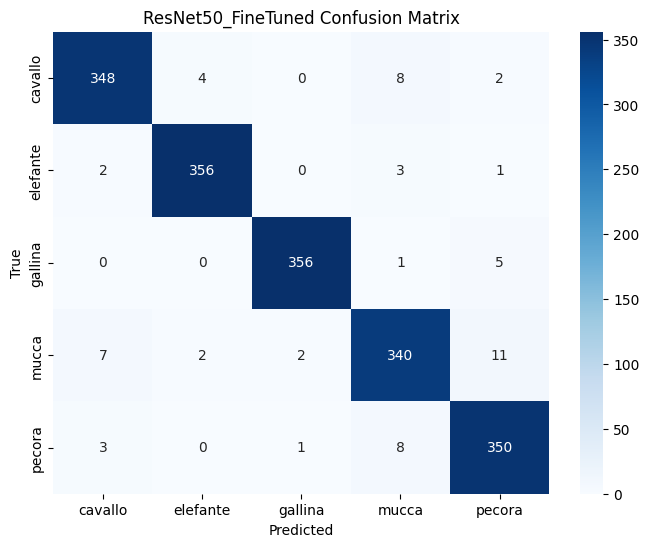

              precision    recall  f1-score   support

     cavallo       0.97      0.96      0.96       362
    elefante       0.98      0.98      0.98       362
     gallina       0.99      0.98      0.99       362
       mucca       0.94      0.94      0.94       362
      pecora       0.95      0.97      0.96       362

    accuracy                           0.97      1810
   macro avg       0.97      0.97      0.97      1810
weighted avg       0.97      0.97      0.97      1810



In [7]:
def evaluate_model(model, name):
    print(f"Evaluating {name}...")
    loss, accuracy = model.evaluate(test_ds)
    print(f"{name} Test Accuracy: {accuracy*100:.2f}%")
    
    y_pred = np.array([])
    y_true = np.array([])
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_pred = np.concatenate([y_pred, np.argmax(preds, axis=1)])
        y_true = np.concatenate([y_true, np.argmax(y, axis=1)])
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=CLASSES))

evaluate_model(model, "ResNet50_FineTuned")